In [309]:
%pylab inline
from pathlib import Path
import sys
path_to_script =  Path("~/projects/scaffan/").expanduser()
sys.path.insert(0,str(path_to_script))
import scaffan
import io3d # just to get data
import scaffan.image as scim

Populating the interactive namespace from numpy and matplotlib


In [554]:
from pathlib import Path
import sklearn.cluster
import sklearn.naive_bayes
import sklearn.svm
from sklearn.externals import joblib


class SVMSegmentation():
    def __init__(self):
        self.anim = None
        self.pixelsize_mm = [0.01, 0.01]
        self.tile_size = [256, 256]
        self.level = None
        self.tiles:List["View"] = None
        self.clf = sklearn.svm.SVC(gamma='scale')
        self.clf_fn = "standard_svm_model.pkl"
        self.clf = joblib.load(self.clf_fn)
        self.predicted_tiles = None
        self.output_label_fn = "label.png"
        self.output_raster_fn = "image.png"
        self.devel_imcrop = None
        self.devel_imcrop = np.array([20000, 15000])
        self.full_output_image = None
        self.full_raster_image = None
        
        pass
    
    def init(self, fn:Path):
        self.anim = scim.AnnotatedImage(fn)
        self.level = self._find_best_level()
        self.tiles = None
        self.predicted_tiles = None
        
    def train_svm_classifier(self, pixels=None, y=None):
        if pixels is None:
            pixels, y =self.prepare_training_pixels()
            
        self.clf.fit(pixels, y=y)
        
    def save_classifier(self):
        joblib.dump(self.clf, 'standard_svm_model.pkl') 
        

    def prepare_training_pixels(self):
        """
        Use annotated image to train classifier.
        Red area is extra-lobular tissue.
        Black area is intra-lobular tissue.
        Magenta area is empty part of the image.
        """
        pixels0, view0 = self._get_pixels(self.anim, "#FF00FF", 0) # empty
        pixels1, view1 = self._get_pixels(self.anim, "#000000", 0) # black
        pixels2, view2 = self._get_pixels(self.anim, "#FF0000", 0) # extra lobula
        labels0 = ones([pixels0.shape[0]]) * 0
        labels1 = ones([pixels1.shape[0]]) * 1
        labels2 = ones([pixels2.shape[0]]) * 2
        pixels = np.concatenate([pixels0, pixels1, pixels2])
        y = np.concatenate([labels0, labels1, labels2])
        
        return pixels, y
        
    def _get_pixels(self, anim, color, n):
        ann_ids = anim.select_annotations_by_color(color)
        view = anim.get_views(ann_ids, level=7)[n]
#         view2 = view.to_pixelsize(pixelsize_mm=pixelsize_mm)
#         view2 = view.to_level(7)
        view2 = view
        img = view2.get_region_image(as_gray=False)

        img_ann = view2.get_annotation_region_raster(ann_ids[n])
        pixels = img[img_ann][:, :3]

        return pixels, view
        
        
    
    def _find_best_level(self):
        error = None
        closest_i = None
        for i, pxsz in enumerate(self.anim.level_pixelsize):
            err = np.linalg.norm(self.pixelsize_mm - pxsz)
            if error is None:
                error = err
                closest_i = i
            else:
                if err < error:
                    error = err
                    closest_i = i
                    
        return closest_i
    
    def _get_tiles_parameters(self):
        height0 = self.anim.openslide.properties['openslide.level[0].height']
        width0 = self.anim.openslide.properties['openslide.level[0].width']

        imsize = np.array([int(width0), int(height0)])
        if self.devel_imcrop is not None:
            imsize = self.devel_imcrop
        
        
        tile_size_on_level = np.array(self.tile_size)
        downsamples = self.anim.openslide.level_downsamples[self.level]
        imsize_on_level = imsize / downsamples
        tile_size_on_level0 = tile_size_on_level * downsamples
        return imsize.astype(np.int), tile_size_on_level0.astype(np.int), tile_size_on_level, imsize_on_level

                    
    def make_tiles(self):
        imsize, size_on_level0, size_on_level, imsize_on_level = self._get_tiles_parameters()
        self.tiles = []
        
        for x0 in range(0, int(imsize[0]), int(size_on_level0[0])):
            column_tiles = []
    
            for y0 in range(0, int(imsize[1]), int(size_on_level0[1])):
                view = self.anim.get_view(location=(x0, y0), size_on_level=size_on_level, level=self.level)
                column_tiles.append(view)
            
            self.tiles.append(column_tiles)
    
    
    def predict_on_image(self, image):
        predicted = self.clf.predict(image[:,:,:3].reshape(-1,3)).astype(np.int)
        img_pred = predicted.reshape(image.shape[0], image.shape[1])
        return img_pred
    
    def predict_tiles(self):
        if self.tiles is None:
            self.make_tiles()
        
        self.predicted_tiles = []
        for tile_view_col in self.tiles:
            predicted_col = []
            for tile_view in tile_view_col:  
                predicted_image = self.predict_on_image(tile_view.get_region_image())
                predicted_col.append(predicted_image)
            self.predicted_tiles.append(predicted_col)
                
        
    
    def predict(self):
        """
        predict tiles and compose everything together
        """
        if self.predicted_tiles is None:
            self.predict_tiles()

        
        
        #         if self.predicted_tiles is None:
#             self.predict_tiles()
        
        szx = len(self.tiles)
        szy = len(self.tiles[0])
#         print(f"size x={szx} y={szy}")
        
        imsize, tile_size_on_level0, tile_size_on_level, imsize_on_level = self._get_tiles_parameters()
        output_image = np.zeros(self.tile_size * np.asarray([szy, szx]), dtype=int )
        for iy, tile_column in enumerate(self.tiles):
            for ix, tile in enumerate(tile_column):
                output_image[
                    ix * self.tile_size[0]: (ix + 1) * self.tile_size[0],
                    iy * self.tile_size[1]: (iy + 1) * self.tile_size[1]
#                     int(x0):int(x0 + tile_size_on_level[0]), 
#                     int(y0):int(y0 + tile_size_on_level[1])    
#                 ] = self.tiles[ix][iy].get_region_image(as_gray=True)
#                 ] = self.tiles[iy][ix].get_region_image(as_gray=True)
                ] = self.predicted_tiles[iy][ix]
                
        full_image = output_image[:int(imsize_on_level[1]), :int(imsize_on_level[0])]
        self.full_output_image = self._labeling_filtration(full_image)
        return self.full_output_image
    
    def _labeling_filtration(self, full_image):
        """
        smooth label 0 and label 1, keep label 2
        """
        tmp_img = full_image.copy()
        tmp_img[full_image == 2] = 1
        import skimage.filters
        tmp_img = skimage.filters.gaussian(tmp_img.astype(np.float), sigma=4)

        tmp_img = (tmp_img > 0.5).astype(np.int)
        tmp_img[full_image == 2] = 2
        return tmp_img
    
    def get_raster_image(self, as_gray=False):
        if self.tiles is None:
            self.make_tiles()
        szx = len(self.tiles)
        szy = len(self.tiles[0])
#         print(f"size x={szx} y={szy}")

        output_size = self.tile_size * np.asarray([szy, szx])
        if not as_gray:
            output_size = np.asarray([output_size[0], output_size[1], 3])
        
        imsize, tile_size_on_level0, tile_size_on_level, imsize_on_level = self._get_tiles_parameters()
        output_image = np.zeros(output_size, dtype=int )
        for iy, tile_column in enumerate(self.tiles):
            for ix, tile in enumerate(tile_column):
                output_image[
                    ix * self.tile_size[0]: (ix + 1) * self.tile_size[0],
                    iy * self.tile_size[1]: (iy + 1) * self.tile_size[1]
#                     int(x0):int(x0 + tile_size_on_level[0]), 
#                     int(y0):int(y0 + tile_size_on_level[1])    
#                 ] = self.tiles[ix][iy].get_region_image(as_gray=True)
                ] = self.tiles[iy][ix].get_region_image(as_gray=as_gray)[:, :, :3]
#                 ] = self.predicted_tiles[iy][ix]
                
        full_image = output_image[:int(imsize_on_level[1]), :int(imsize_on_level[0])]
        self.full_raster_image = full_image
        return full_image
    
    def evaluate(self):
        _, count = np.unique(self.full_output_image, return_counts=True)
        self.intralobular_ratio = count[1] / (count[1] + count[2])
#         plt.figure(figsize=(10, 10))
#         plt.imshow(self.full_output_image)
        plt.imsave(self.output_label_fn, self.full_output_image)
        
#         plt.figure(figsize=(10, 10))
        img = self.get_raster_image(as_gray=False)
#         plt.imshow(img)
        plt.imsave(self.output_raster_fn, img.astype(np.uint8))
        
    
    
    def run(self):
        self.predict()
        self.evaluate()
    
        
        



# Example

In [480]:
fn = io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0165_HE.ndpi", get_root=True)
print(f"filename: {fn}")

filename: C:\Users\Jirik/data/medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi


In [555]:
seg = SVMSegmentation()
seg.init(fn)
# seg._find_best_level()

2019-09-20 23:32:48.801 | DEBUG    | scaffan.image:__init__:173 - Reading file C:\Users\Jirik/data/medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi
2019-09-20 23:32:48.812 | DEBUG    | scaffan.image:__init__:187 - Reading the annotation
2019-09-20 23:32:50.578 | DEBUG    | scaffan.annotation:read_annotations:119 - windows annotation output:b'2019-09-20 23:32:50.379 | DEBUG    | scaffan.annotation:ndpa_to_json:71 - PATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\r\n'


# Training

In [478]:
# seg.train_svm_classifier()
# seg.save_classifier()

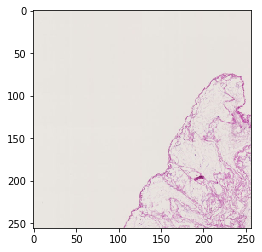

In [500]:
seg.make_tiles()
img = seg.tiles[1][1].get_region_image()
plt.imshow(img)

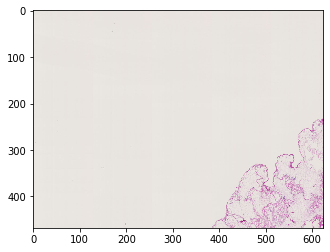

In [525]:
plt.imshow(seg.get_input_image())

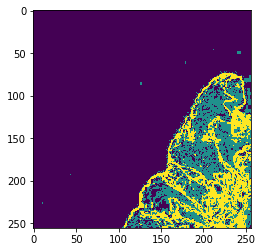

In [483]:
pred = seg.predict_on_image(img)
plt.imshow(pred)

In [484]:
# seg.predict_tiles()

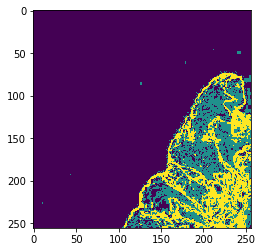

In [485]:
# plt.imshow(seg.predicted_tiles[1][1])

In [492]:
full_image = seg.predict()
seg.full_output_image

In [251]:
# def predict(self):
# #         if self.predicted_tiles is None:
# #             self.predict_tiles()
        
#         szx = len(self.tiles)
#         szy = len(self.tiles[0])
#         print(f"size x={szx} y={szy}")
        
#         imsize, tile_size_on_level0, tile_size_on_level, imsize_on_level = self._get_tiles_parameters()
#         output_image = np.zeros(self.tile_size * np.asarray([szy, szx]), dtype=int )
#         for iy, tile_column in enumerate(self.tiles):
#             for ix, tile in enumerate(tile_column):
#                 output_image[
#                     ix * self.tile_size[0]: (ix + 1) * self.tile_size[0],
#                     iy * self.tile_size[1]: (iy + 1) * self.tile_size[1]
# #                     int(x0):int(x0 + tile_size_on_level[0]), 
# #                     int(y0):int(y0 + tile_size_on_level[1])    
# #                 ] = self.tiles[ix][iy].get_region_image(as_gray=True)
# #                 ] = self.tiles[iy][ix].get_region_image(as_gray=True)
#                 ] = self.predicted_tiles[iy][ix]
                
#                 pass
#         full_image = output_image[:int(imsize_on_level[1]), :int(imsize_on_level[0])]
#         return full_image
# full_image = predict(seg)

size x=7 y=6


In [556]:
seg.run()

In [544]:
plt.imsave('pokus.png', seg.full_output_image)

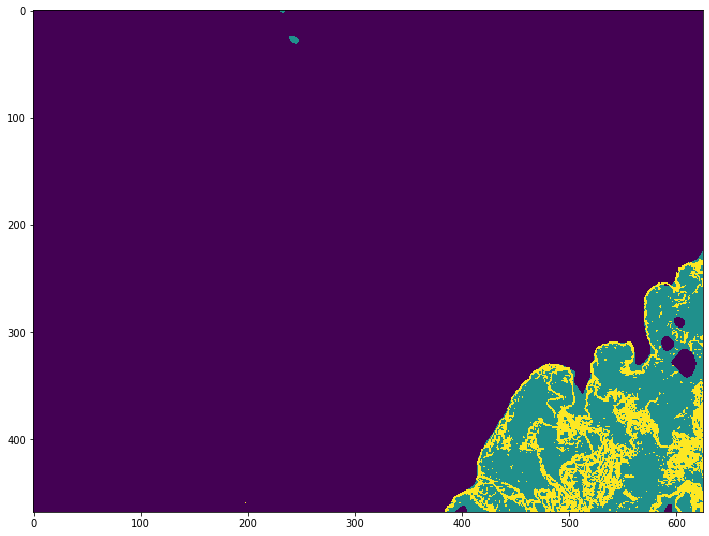

In [497]:

plt.figure(figsize=(12,12))
plt.imshow(
    seg.full_output_image
#     full_image[500:1000, 500:1000]
)
# plt.colorbar()

In [529]:
tmp_seg.full_output_image

In [527]:
import scipy.ndimage
# dist = scipy.ndimage.morphology.distance_transform_edt(tmp_img != 2)
dist = scipy.ndimage.morphology.distance_transform_edt(tmp_img == 1)

plt.imshow((tmp_img !=2).astype(np.int))

AttributeError: 'bool' object has no attribute 'astype'

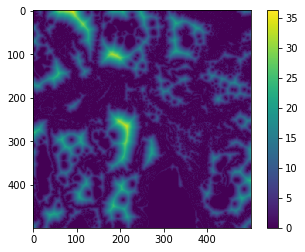

In [445]:
plt.imshow(dist)
plt.colorbar()

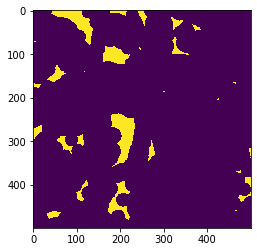

In [448]:
plt.imshow(dist > 15)

In [292]:
tmp_img > 0.5

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False]])

In [257]:
_, count = np.unique(full_image, return_counts=True)

intralobular_ratio = count[2] / (count[1] + count[2])

intralobular_ratio

0.35995119921974683

In [110]:
seg.predicted_tiles[41]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [245]:
full_image

In [ ]:
seg